# Simple Error Model for Twinkles

This notebook will calculate a simple error model for the Twinkles data as a function of the seeing and depth.

## Requirements

You will need the DESC `Monitor` and its dependencies.

You will also need the truth database and Opsim database for the desired Twinkles run. This example uses the run 1.3 settings and thus we use `minion_1016` as our Opsim database.

## Motivation for an Error Model

The Error Model will be a way to estimate the uncertainties in the Twinkles data from the properties of a visit and an object. There are three major motivations behind this:

1.  Develop a method to rapidly simulate large amounts of catalog level datasets for time-variable astronomical objects without the need for image simulation.
2.  Understand the uncertainties that will be present in observed data to improve the likelihoods that we will use for Bayesian estimates of other properties such as the time delays for strongly lensed AGN or the detections of Supernovae.
3.  Look for evidence of systematic errors related to image processing.

So far, we have worked on modeling the relationships between flux uncertainties and the observed seeing and 5 sigma depth of a visit.

## Import necessary modules

Don't worry about the warnings below.

In [1]:
import os
import desc.monitor
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lsst.sims.photUtils import calcNeff
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


### Load necessary database connections.

The Monitor has the ability to load the true fluxes and the observed fluxes (stored in MySQL databases on NERSC) for us. If you are not running this on jupyter-dev you will have to open an ssh-tunnel as described in the Monitor package setup.

Let's start by specifying the location of our truth database and setting up a truth database connection.

Since we are using the same field and chip in run 1.1 and 1.3 we can use the run 1.1 stars database without issues.

In [33]:
star_db_name = '../../twinkles_run1.1.db'
truth_dbConn = desc.monitor.truthDBInterface(database=star_db_name, driver='sqlite')

Then we'll establish a database connection to the NERSC MySQL database for the observed data from Twinkles.

In [34]:
twinkles_dbConn = desc.monitor.dbInterface(database='DESC_Twinkles_Level_2',
                                           #host='127.0.0.1', port='3307',  ##if not running jupyter-dev
                                           host='scidb1.nersc.gov', port=3306,
                                           driver='mysql', project='Twinkles Run3')

And finally we'll establish the connection the Opsim database.

In [9]:
#opsim_dbConn = desc.monitor.opsimDBInterface('../../kraken_1042_sqlite.db')  ##Run 1.1 Opsim database
opsim_dbConn = desc.monitor.opsimDBInterface('../../minion_1016_sqlite.db')

### Load the visit info from DM and from Opsim

Our simplest error model wants to model flux errors as a function of visit seeing and 5-sigma depth. Therefore, we will need to pull this info from Opsim and from the DM databases to compare. The Monitor is set up to do this too.

In [10]:
dm_visit_info = twinkles_dbConn.get_all_visit_info()

In [11]:
opsim_info = opsim_dbConn.get_summary_depth_info_for_visits(1427)

In [12]:
#Find entries with the proper obsHistIds in the Opsim data to match the Twinkles run
obs_list = []
for visit_id in dm_visit_info['visit_id']:
    obs_list.append(np.where(opsim_info['obsHistID'] == visit_id)[0][0])

### Use Monitor to assemble depth and seeing curves

We use the CcdVisit table to populate our 5-sigma depth curves and the seeing curves with the DM-measured values from each visit. We name our instance of the `Monitor` a `worker` since it does all the work of gathering data for us.

In [8]:
worker = desc.monitor.Monitor(twinkles_dbConn, truth_dbConn=truth_dbConn)

In [9]:
depth_curve = worker.measure_depth_curve()

In [10]:
seeing_curve = worker.measure_seeing_curve()

## Comparing 5-sigma depth:

#### Data Management Calculated Depth

*  We use values from `CcdVisit` table in our `Twinkles` pserv database along with the following adapted from LSE-40, http://www.astro.washington.edu/users/ivezic/Teaching/Astr511/LSST_SNRdoc.pdf. 

    * `seeing` is a value direct from the `CcdVisit` table.
    * $Noise$ is equivalent to the `sky_noise` values in the `CcdVisit` table.
    * $zero\_point$ below is the `zero_point` value in the `CcdVisit` table.

    We have that for a single Gaussian profile and in the $\textbf{background dominated limit}$:
    
    $n_{eff} = 2.266*(\frac{seeing}{pixel\_scale})^{2}$

    $SNR = \frac{Signal}{Noise}$

    $SNR = \frac{Source\_Counts}{\sigma_{tot}*\sqrt{n_{eff}}}$

    So that, SNR = 5 gives

    $Source\_Counts_{5\sigma} = 5 * \sigma_{tot} * \sqrt{n_{eff}}$

    and to convert to flux in maggies we scale by the zeropoint and then multiply by 1e9 to get nanomaggies.

    $F_{5} = \frac{10^{9}* Source\_Counts_{5\sigma}}{zero\_point}$

    But, the version we use in the `monitor` is modified a bit to account for the Poisson noise of the source and thus derive a general form outside of the background dominated limit.

    $SNR = \frac{Signal}{\sqrt{Signal + Noise^2}}$

    $SNR = 5 = \frac{Source\_Counts_{5\sigma}}{\sqrt{Source\_Counts_{5\sigma} + (\sigma_{tot}*\sqrt{n_{eff}})^2}}$

    We solve this as a quadratic equation and take the positive root.

    $Source\_Counts_{5\sigma} = \frac{25 + 25*\sqrt{1 + \frac{4}{25}*(\sigma_{tot}*\sqrt{n_{eff}})^2}}{2}$

    and once again convert to flux in nanomaggies using the zeropoint and 1e9 conversion factor.

    These results are the $\color{red}{red\ line}$ in the plot below.

#### Opsim Depth

*  We compare the results from DM with the `FWHMeff` values from the `Summary` table in the Opsim database.


#### Note: Currently some values in Run 3 CcdVisit tables have nans. 

See https://github.com/LSSTDESC/Twinkles/issues/439.

The following is a temporary hack.

In [11]:
use_idx = np.where(np.isnan(depth_curve.lightcurve['mag']) == False)[0]
dm_visit_info = dm_visit_info[use_idx]
depth_curve.lightcurve = depth_curve.lightcurve.iloc[use_idx, [0,1,2,3,4]]
seeing_curve.seeing_curve = seeing_curve.seeing_curve.iloc[use_idx, [0,1,2,3]]
opsim_info = opsim_info[obs_list][use_idx]

Now we will plot and compare the two values for 5-sigma depth we get.

(0, 6500)

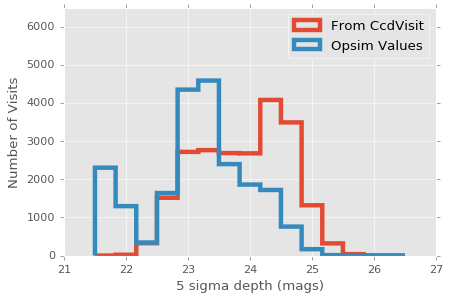

In [12]:
fig = plt.figure()
bins = 15
n,bins,p = plt.hist(depth_curve.lightcurve['mag'], histtype='step', lw=4, bins=15, label='From CcdVisit', range=(21.5,26.5))
plt.hist(opsim_info['fiveSigmaDepth'], histtype='step', bins=bins, lw=4, label='Opsim Values')
plt.legend()
plt.xlabel('5 sigma depth (mags)')
plt.ylabel('Number of Visits')
plt.ylim(0, 6500)

And here we plot by filter.

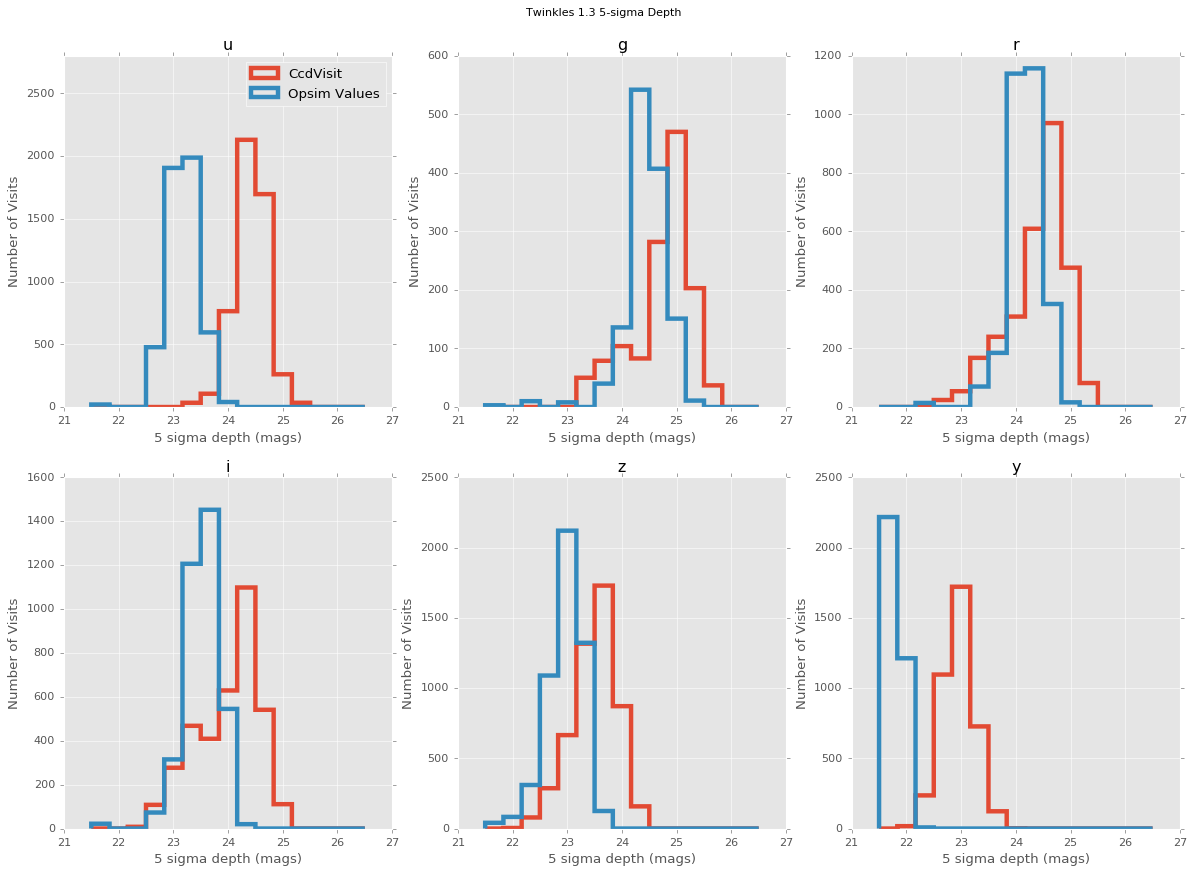

In [13]:
fig = plt.figure(figsize=(18, 12))
fig_num = 1
for filter_val in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,fig_num)
    n,bins,p = plt.hist(depth_curve.lightcurve['mag'][depth_curve.lightcurve['bandpass'] == str('lsst'+filter_val)], 
                        histtype='step', lw=4, bins=15, label='CcdVisit', range=(21.5,26.5))
    plt.hist(opsim_info['fiveSigmaDepth'][opsim_info['filter'] == filter_val], histtype='step', bins=bins, lw=4, label='Opsim Values')
    if fig_num == 1:
        plt.legend()
    plt.xlabel('5 sigma depth (mags)')
    plt.ylabel('Number of Visits')
    if fig_num == 1:
        plt.ylim(0, 2800)
    plt.title(filter_val)
    fig_num += 1
plt.suptitle('Twinkles 1.3 5-sigma Depth')
plt.subplots_adjust(top=0.93)

It looks like there are discrepancies between the DM measured values and the Opsim values. We need to look into this. It looks like the DM calculated values are consistently deeper than the Opsim depth. Also, the effect looks the worst in the u and y filters.

## Seeing Comparison

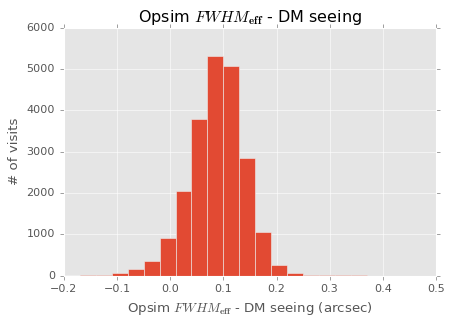

In [14]:
plt.hist(opsim_info['FWHMeff'] - seeing_curve.seeing_curve['seeing'], range=(-0.2, 0.4), bins=20)
plt.title(r'Opsim $FWHM_{\bf{eff}}$ - DM seeing')
plt.xlabel(r'Opsim $FWHM_{\bf{eff}}$ - DM seeing (arcsec)')
plt.ylabel('# of visits')

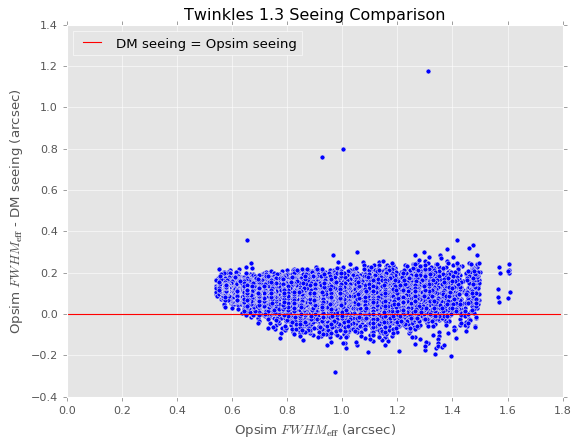

In [15]:
fig = plt.figure(figsize=(8,6))
plt.scatter(opsim_info['FWHMeff'], opsim_info['FWHMeff'] - seeing_curve.seeing_curve['seeing'])
l1, = plt.plot(np.arange(0, 1.8, 0.01), np.zeros(len(np.arange(0, 1.8, 0.01))), c='r', label='DM seeing = Opsim seeing')
plt.xlim(0, 1.8)
#plt.ylim(0, 1.8)
plt.xlabel(r'Opsim $FWHM_{\bf{eff}}$ (arcsec)')
plt.ylabel(r'Opsim $FWHM_{\bf{eff}}$ - DM seeing (arcsec)')
plt.legend([l1], ['DM seeing = Opsim seeing'], loc=2)
plt.title('Twinkles 1.3 Seeing Comparison')
#plt.savefig('/Users/Bryce/Desktop/seeing_compare.png')

There are also discrepencies here as well. It seems like the DM values are consistently under the Opsim values.

## Comparing measured fluxes to the simulation "truth"

In the rest of this notebook we compare the DM measured flux values to the "true" values that we know from the input catalogs to the simulation. We start with a position matching method that finds matches between the objects of the observed catalogs and the truth catalogs based upon angular distance.

Then the worker calculates the flux residuals _(observed - truth)_ and finds the mean and variance of this value among the objects in each visit.

**Note:** The following is currently Run 1.1 data since we have not finished the run 3 processing. As soon as it is available we will update these plots with 1.3 data.

In [29]:
distances = worker.match_catalogs(return_distance=True, within_radius=1./3600.)

Querying Truth Catalog
Querying Pserv Database
Starting angular crossmatch
Done


In [37]:
worker.calc_flux_residuals(with_depth_curve=depth_curve, with_seeing_curve=seeing_curve)

Gathering Visit Data
Querying for object fluxes
Loaded 0 out of 698 objects
Loaded 100 out of 698 objects
Loaded 200 out of 698 objects
Loaded 300 out of 698 objects
Loaded 400 out of 698 objects
Loaded 500 out of 698 objects
Loaded 600 out of 698 objects


/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:275: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  obs_flux_table['obs_object_id'] = obs_flux_table['obs_object_id'].convert_objects(convert_numeric=True)
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:276: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  obs_flux_table['visit_id'] = obs_flux_table['visit_id'].convert_objects(convert_numeric=True)
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:277: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  obs_flux_table['psf_flux'] = obs_flux_table['psf_flux'].convert_objects(convert_numeric=True)
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:278: Future

## Plotting Bias and Sigma

Now that we have the data we need in the form of mean flux residuals and mean squared flux residuals for each visit we can combine this with our depth and seeing information to construct plots that show the bias and sigma as functions of these values.

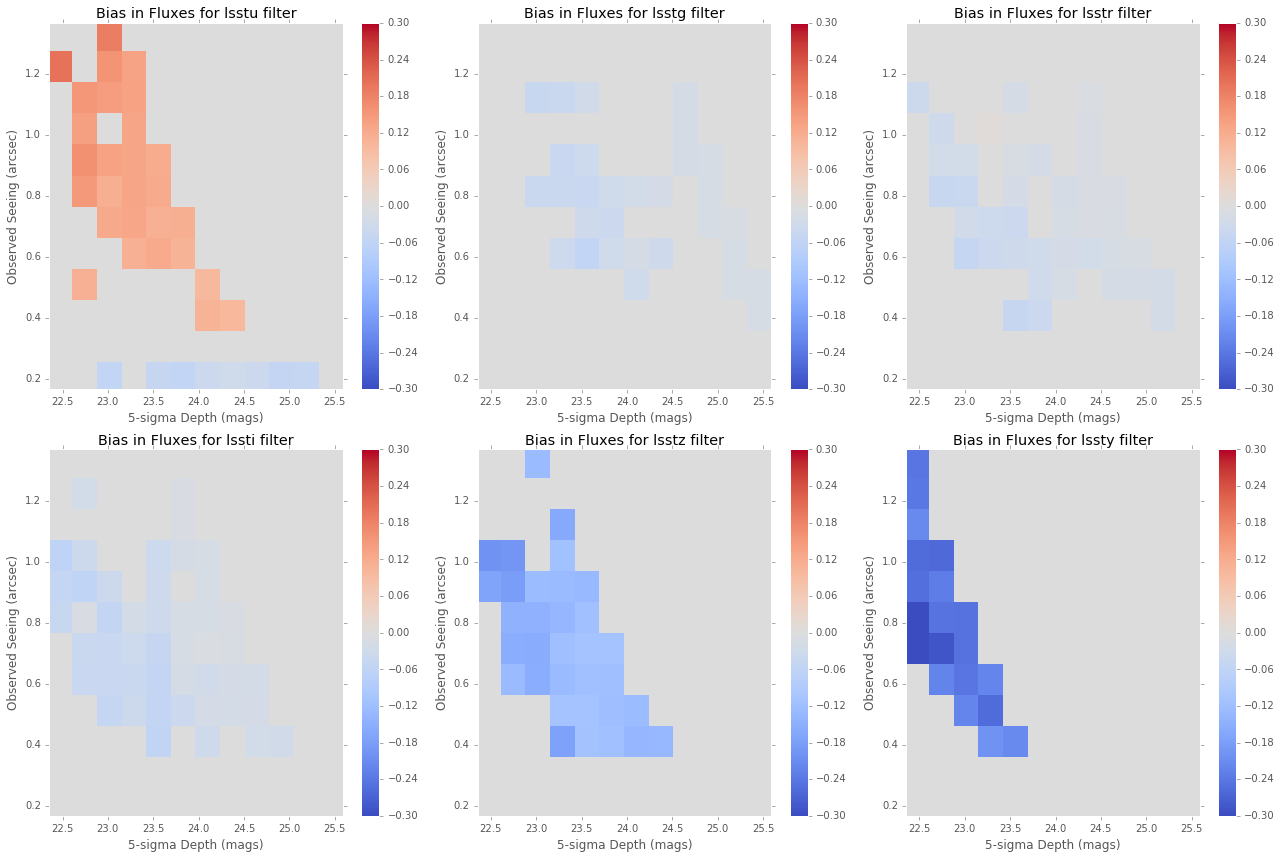

In [63]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_map(with_bins=12, in_band=band, use_existing_fig=fig)
    i+=1
plt.tight_layout()

/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor

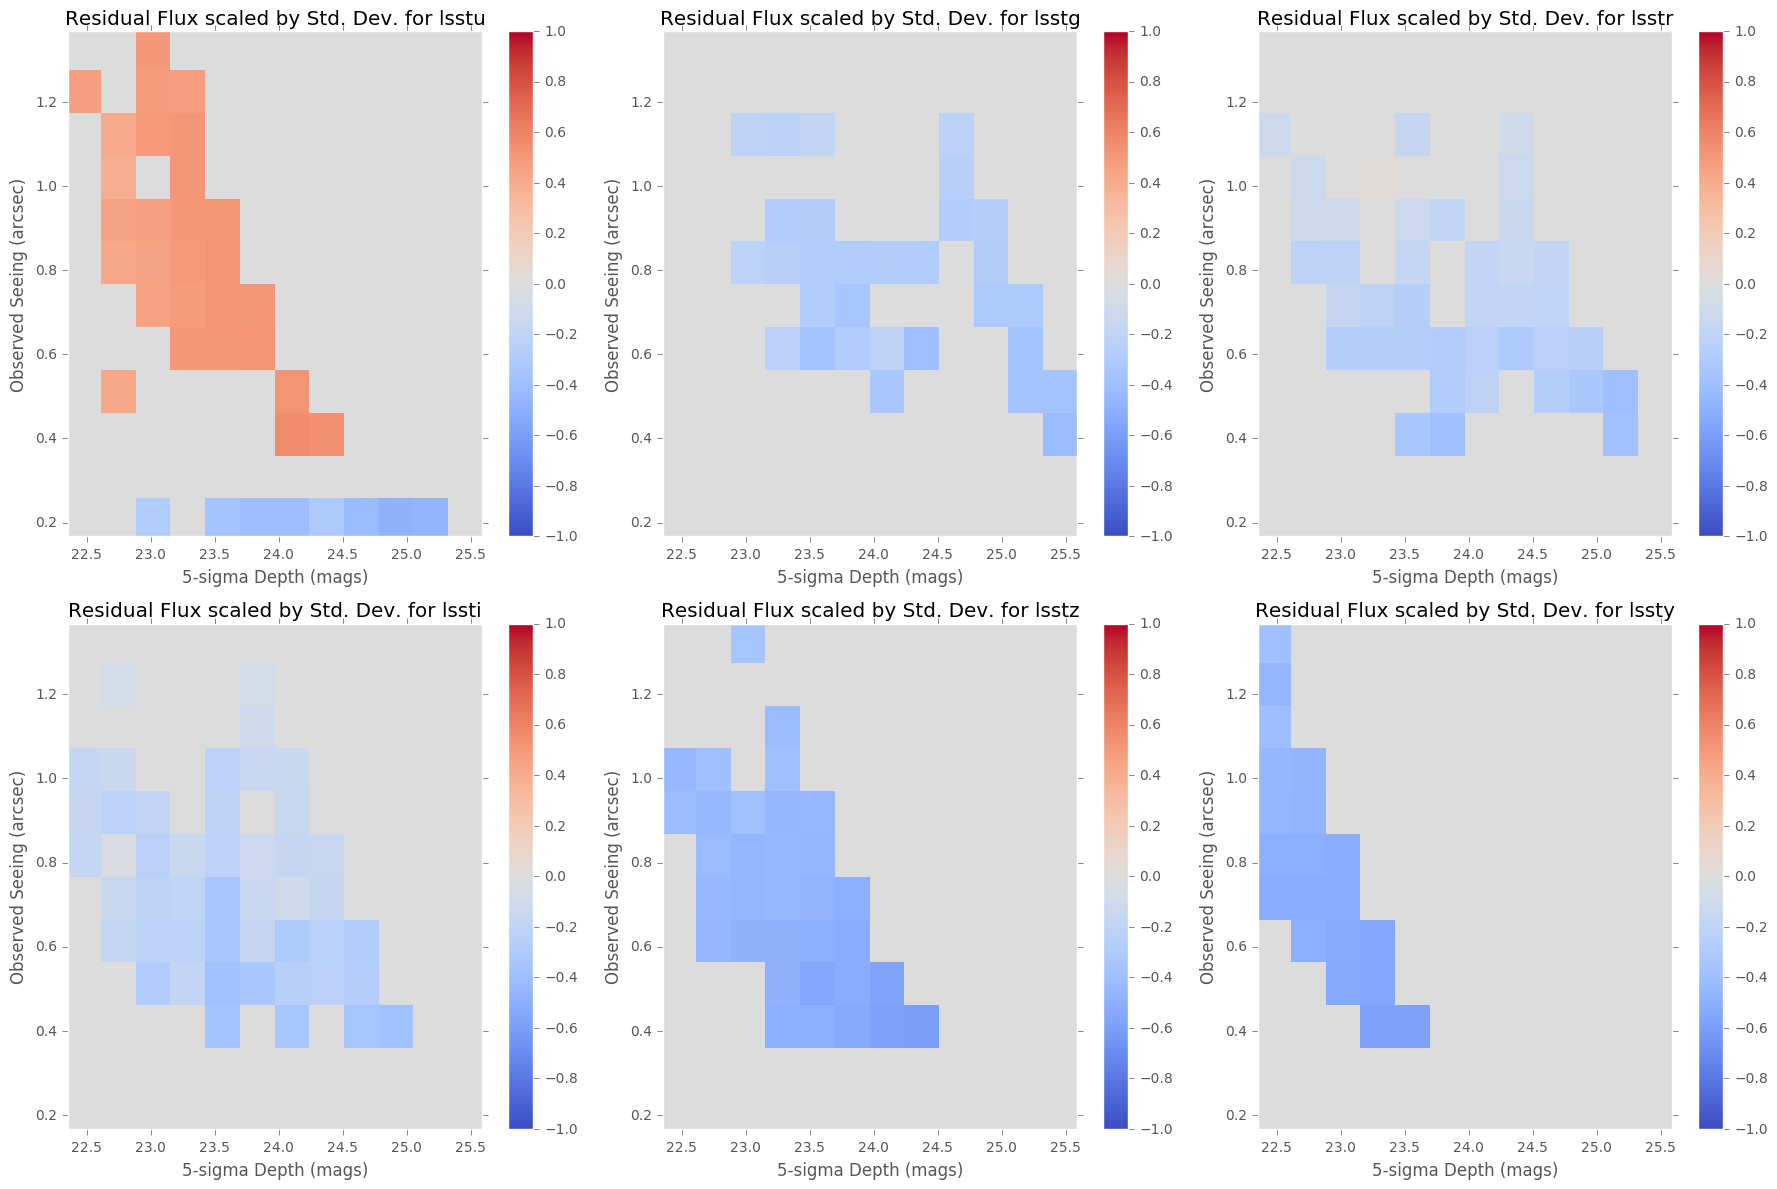

In [40]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_map(with_bins=12, in_band=band, use_existing_fig=fig,
                         normalize=True)
    i+=1
plt.tight_layout()

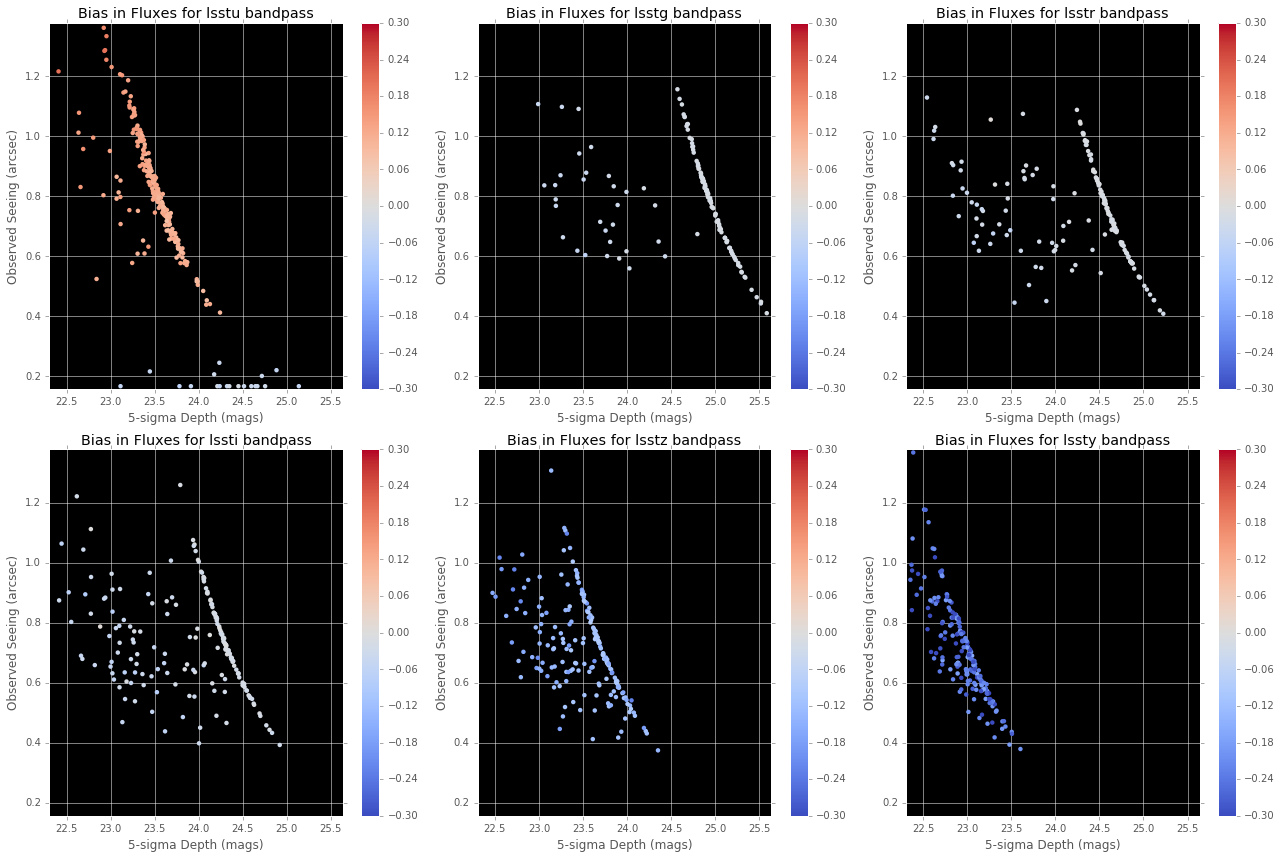

In [65]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_scatter(in_band=band, use_existing_fig=fig)
    i+=1
    plt.gca().set_axis_bgcolor('k')
plt.tight_layout()

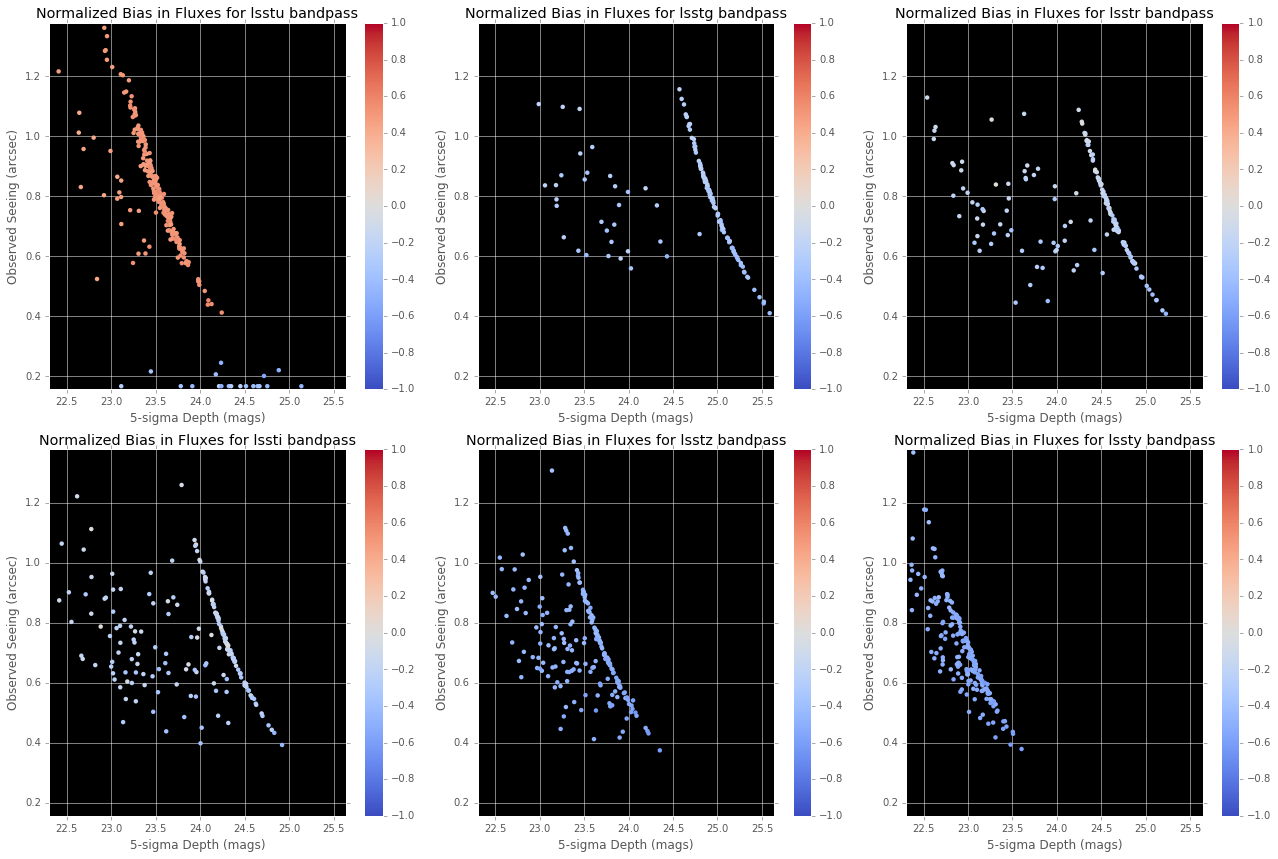

In [66]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_bias_scatter(in_band=band, use_existing_fig=fig, normalize=True)
    i+=1
    plt.gca().set_axis_bgcolor('k')
plt.tight_layout()

/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor/python/desc/monitor/monitor.py:448: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (self.flux_stats['bandpass'] == in_band))]
/Users/Bryce/Documents/DESC/monitor

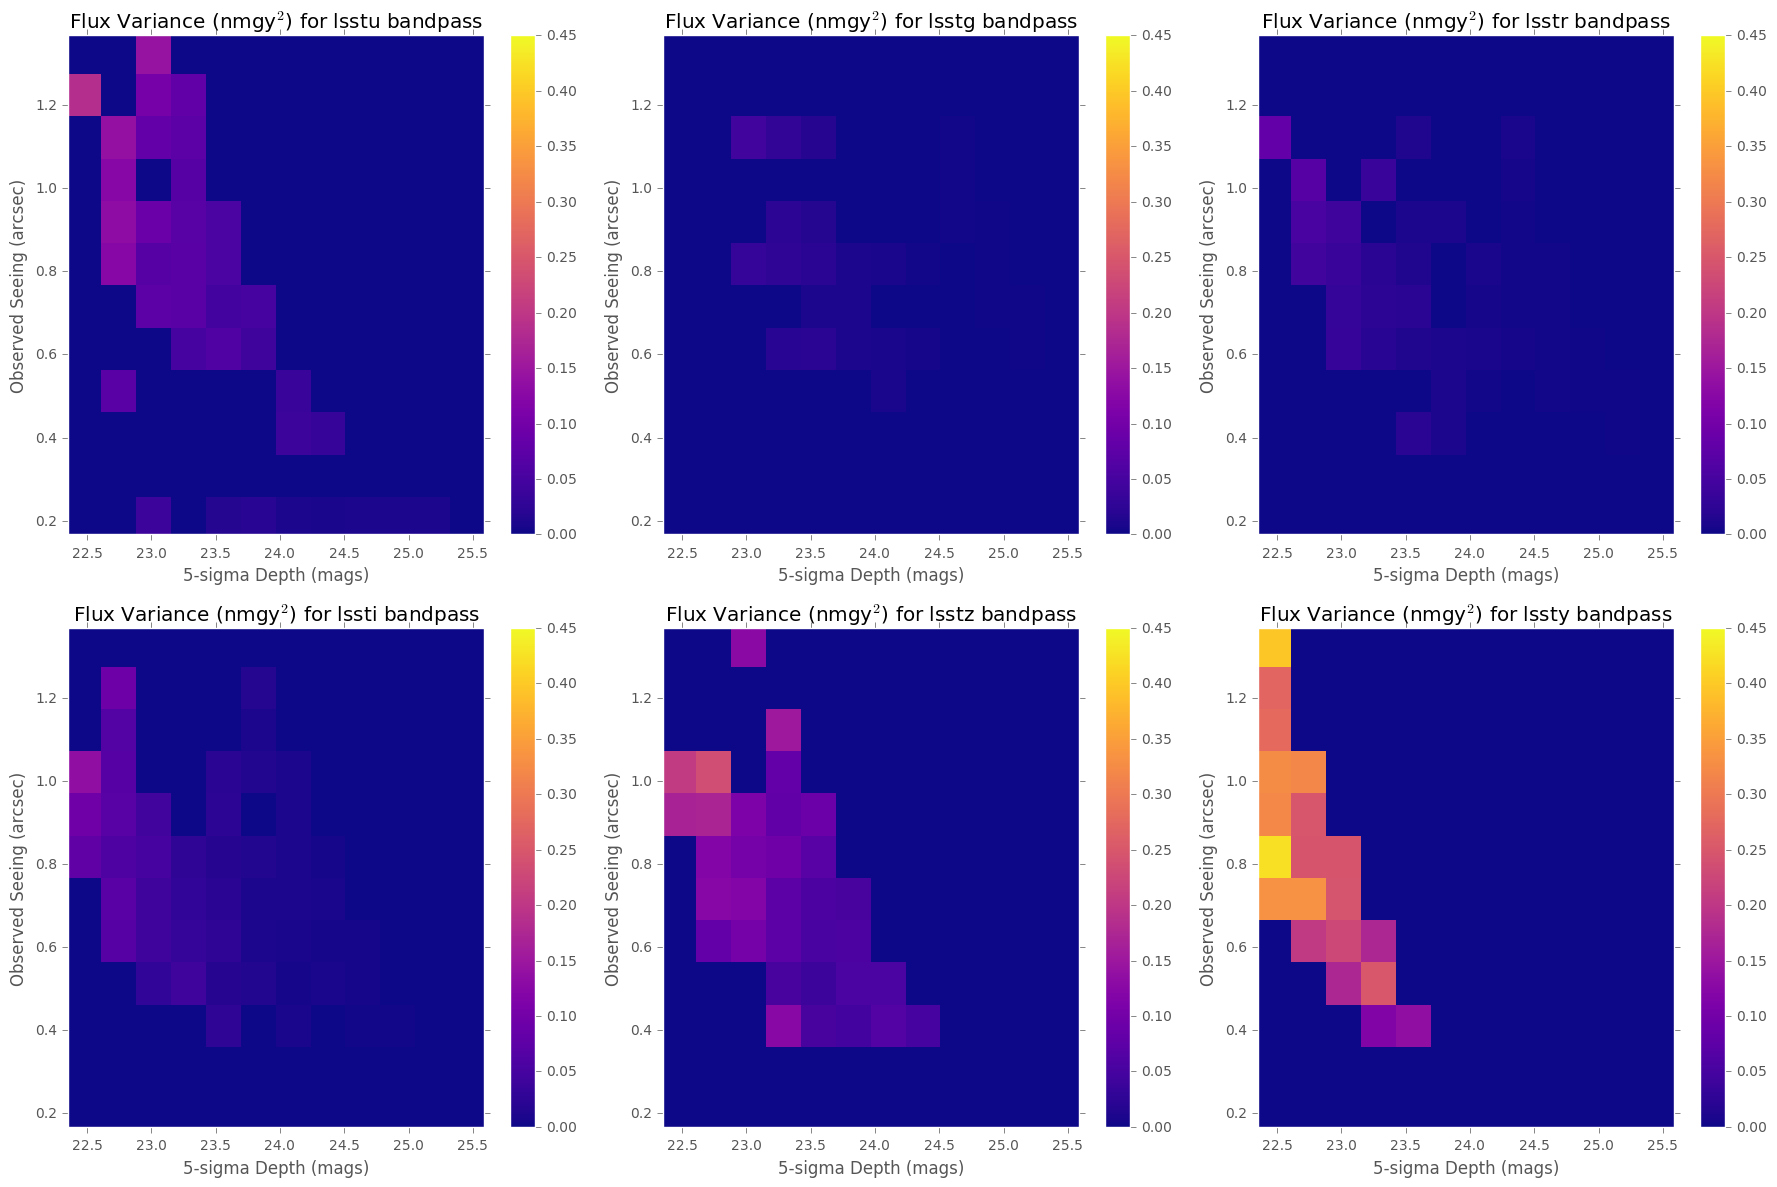

In [43]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_variance_map(with_bins=12, in_band=band, use_existing_fig=fig)
    i+=1
plt.tight_layout()

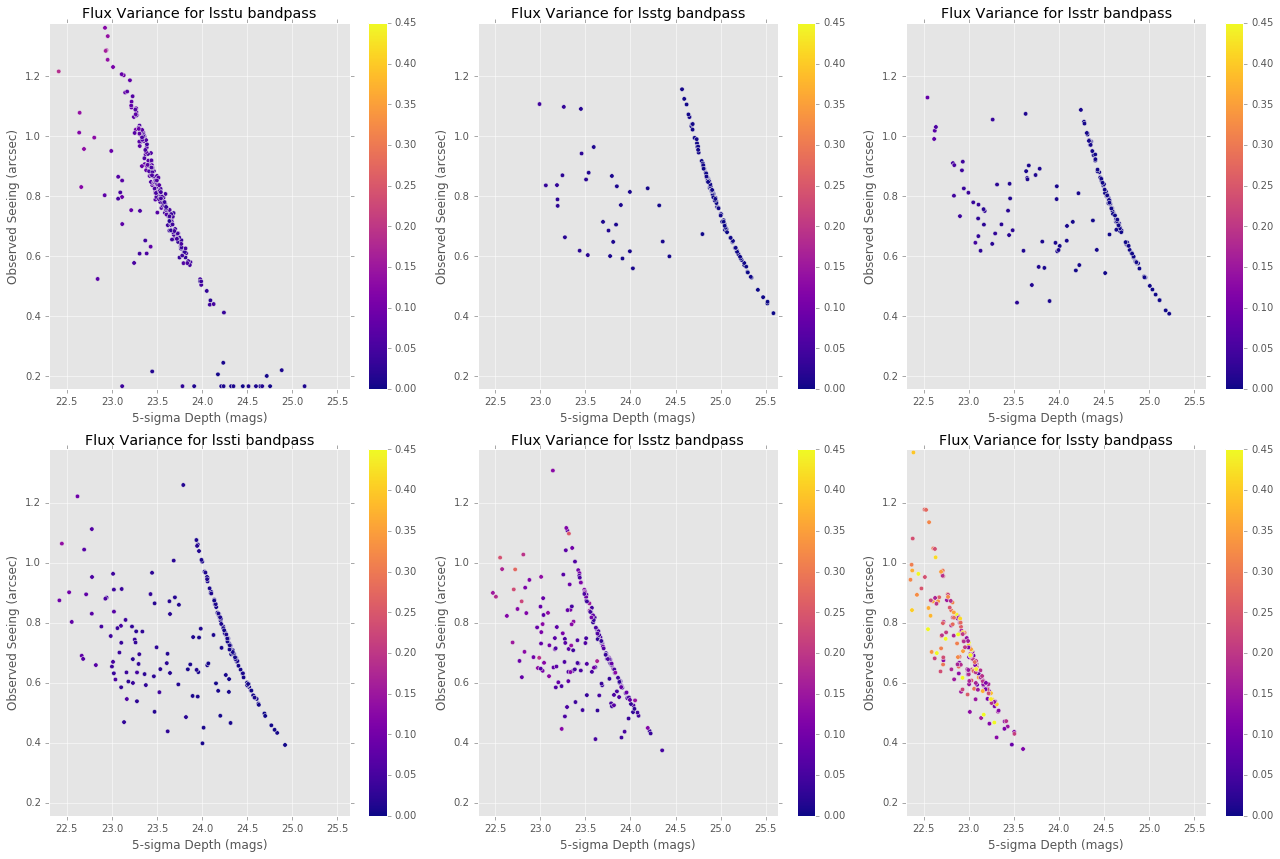

In [41]:
fig = plt.figure(figsize=(18,12))
i=1
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    fig.add_subplot(2,3,i)
    worker.plot_variance_scatter(in_band=band, use_existing_fig=fig)
    i+=1
plt.tight_layout()

## Conclusions

The bias and variance maps show a similar per-band effect as the depth and seeing comparisons above and show that our priority task right now is to figure out why the depth and seeing disparities are occurring.

In [44]:
len(visit_info)

1120